# RL Assignment 02
Name : Vishal Ghorpade
---
Number at Poly:2175243
---
UdeM Matricule: 20170516
---

# Frozen Lake Environment

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import gym
import numpy as np
import operator
from IPython.display import clear_output
from time import sleep
import random
import itertools
import tqdm

tqdm.monitor_interval = 0
%matplotlib inline  

# matplotlib.use('Agg')

In [ ]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils

from gym import Env, spaces
from gym.utils import seeding

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "2x2": ["SF", "HG"],
    "4x4-easy":["SFFF", "FHFF", "FFFF", "HFFG"],
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}


def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()


class DiscreteEnv(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """

    def __init__(self, nS, nA, P, isd, max_length=100, termination_penalty=-50):
        self.P = P
        self.isd = isd
        self.lastaction = None  # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.max_length = max_length
        self.termination_penalty = termination_penalty

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        self.t = 0
        return int(self.s)

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        if self.t >= self.max_length:
            d = True
            r = self.termination_penalty
        self.t += 1
        return (int(s), r, d, {"prob": p})


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the
    park when you made a wild throw that left the frisbee out in the middle of
    the lake. The water is mostly frozen, but there are a few holes where the
    ice has melted. If you step into one of those holes, you'll fall into the
    freezing water. At this time, there's an international frisbee shortage, so
    it's absolutely imperative that you navigate across the lake and retrieve
    the disc. However, the ice is slippery, so you won't always move in the
    direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self, desc=None, map_name="4x4", slip_rate=0.5):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b"S").astype("float64").ravel()
        isd /= isd.sum()

        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            # reward = float(newletter == b"G")
            reward = -1
            # if newletter == b"H":
            #     reward = -100
            done = False
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter == b"G":
                        li.append((1.0, s, 0, True))
                    if letter == b'H':
                        li.append((1.0, s, -100, True))
                    else:
                        if slip_rate > 0:
                            li.append((slip_rate/2.0, *update_probability_matrix(row, col, (a - 1) % 4)))
                            li.append((1 - slip_rate, *update_probability_matrix(row, col, a)))
                            li.append((slip_rate/2.0, *update_probability_matrix(row, col, (a + 1) % 4)))
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(
                "  ({})\n".format(["Left", "Down", "Right", "Up"][self.lastaction])
            )
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

In [ ]:
def create_random_policy(env):
    policy = np.empty((env.observation_space.n,env.action_space.n))#zeros((env.observation_space.n,env.action_space.n))
    policy.fill(1/env.action_space.n)
    # print("policy",policy)
    return policy

In [ ]:
def create_state_action_dictionary(env):
    Q = np.zeros((env.observation_space.n,env.action_space.n))
    # for key in policy.keys():
    #      Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
    return Q

# Answer 1:

## 1.1 Generate Episode

In [ ]:
def generate_episode(env, policy, render=False):
    env.reset()
    episode = []
    done = False
    s = env.s
#     print("P",policy[s,:])
    while not done:
        if render:
#             clear_output(True)
            env.render()
            sleep(1)
        timestep = []
        timestep.append(s)
        n = random.uniform(0, sum(policy[s]))
        top_range = 0
#         print("P",policy[s,:])
        action = np.random.choice(env.action_space.n,1,p=policy[s,:])[0]
        # for k in range(env.action_space.n):
        #     top_range +=policy[s][k]
        #     if n < top_range:
        #         action = k
        #         break
        s_t, reward, done, info = env.step(action)
        timestep.append(action)
        timestep.append(reward)
        episode.append(timestep)
        s = s_t
    if render:
#         clear_output(True)
        env.render()
        sleep(1)
    return episode

In [ ]:
env = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

## 1.2 First Visit Monte Carlo with e-soft policy

In [ ]:
def monte_carlo_e_soft(env, episodes=2000, p=None, epsilon=0.05,gamma = 0.99):
    if not p:
        policy = create_random_policy(env)  # Create an empty dictionary to store state action values    
    Q = create_state_action_dictionary(env)#, policy) # Empty dictionary for storing rewards for each state-action pair
    returns = {} 
    log_returns_per_episode = []
#     print("poli 1",policy)
#     gamma = 0.99
    log_undiscounted = []
    for i in range(episodes): # Looping through episodes
        G = 0 # Store cumulative reward in G (initialized at 0)
        # print("episode",i)
#         print("poli",policy)
        episode = generate_episode(env=env, policy=policy, render=False) # Store state, action and value respectively 
        U_G = 0      
        for i in reversed(range(0, len(episode))):   
            s_t, a_t, r_t = episode[i] 
            state_action = (s_t, a_t)
            G = G*gamma + r_t # Increment total reward by reward on current timestep modify 
            U_G +=r_t
            if not state_action in [(x[0], x[1]) for x in episode[0:i]]: # 
                if returns.get(state_action):
                    returns[state_action].append(G)
                else:
                    returns[state_action] = [G]   
                    
                Q[s_t][a_t] = sum(returns[state_action]) / len(returns[state_action]) # Average reward across episodes
                
                Q_list = list(Q[s_t])#list(map(lambda x: x[1], Q[s_t].items())) # Finding the action with maximum value
                indices =  [i for i, x in enumerate(Q_list) if x == max(Q_list)] #np.where(Q_list == Q_list.max()).tolist()#
                # print(indices)                
                A_star = random.choice(indices)# max_Q 
                
                for a in range(env.action_space.n): # Update action probability for s_t in policy
                    # print("a",a,"A_star",A_star)
                    if a == A_star:
                        policy[s_t][a] = 1 - epsilon + (epsilon / 4)
                    else:
                        policy[s_t][a] = (epsilon / 4)
        log_returns_per_episode.append(G)
        log_undiscounted.append(U_G)
    return policy, log_returns_per_episode,log_undiscounted

In [ ]:
seed = 1025
all_policy = []
log_returns_per_run = []
log_u_rt = []
for i in range(20):
    env.seed(1025)
    env.reset()
    # print("i",i)
    # print("-------")
    policy,log_returns_per_episode,log_undiscounted_rt = monte_carlo_e_soft(env,episodes=2000,epsilon=0.05,gamma=0.99)
    all_policy.append(policy)
    log_returns_per_run.append(log_returns_per_episode)
    log_u_rt.append(log_undiscounted_rt)

### 1.2 (a) Plot of Undiscounted returns after 2000 Episodes

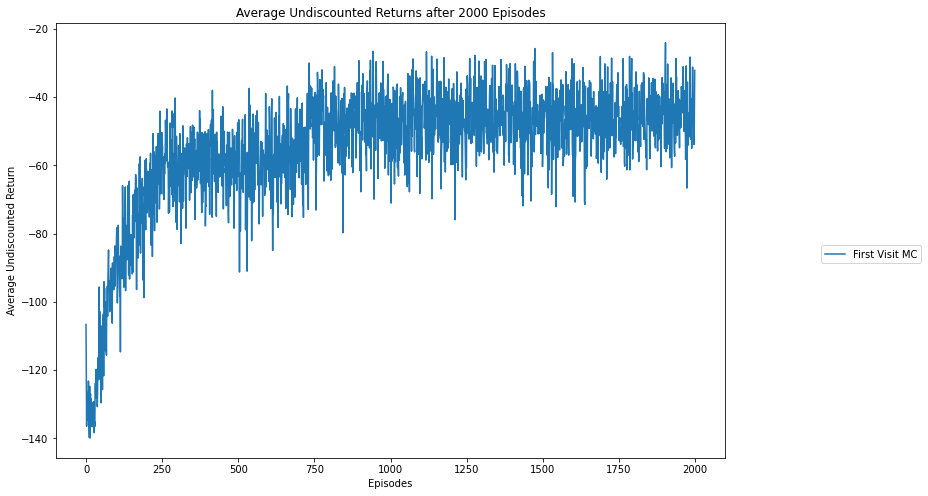

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.asarray(log_u_rt).mean(axis=0),label='First Visit MC')
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("Average Undiscounted Return")
plt.title("Average Undiscounted Returns after "+ str(2000) + " Episodes")
plt.show()


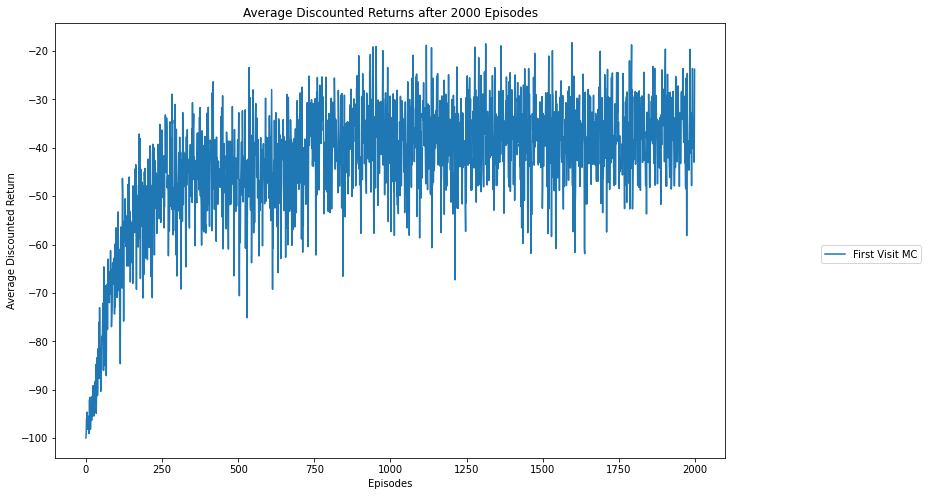

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.asarray(log_returns_per_run).mean(axis=0),label='First Visit MC')
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("Average Discounted Return")
plt.title("Average Discounted Returns after "+ str(2000) + " Episodes")
plt.show()


### 1.2 (b) Visualize an episode with learned policy

In [ ]:
def visualize_episode(env,policy):
    env.reset()
    episode = []
    done = False
    s = env.s
    render = True
    while not done:
        if render:
            env.render()
            sleep(1)
        timestep = []
        timestep.append(s)
        # n = random.uniform(0, sum(policy[s]))
        # top_range = 0
        # for k in range(env.action_space.n):
        #     top_range +=policy[s][k]
        #     if n < top_range:
        #         action = k
        #         break
        action = np.random.choice(env.action_space.n,1,p=policy[s,:])[0]
        s, reward, done, info = env.step(action)
        timestep.append(action)
        timestep.append(reward)
        episode.append(timestep)

    env.render()
    sleep(1)
    # return episode
    

In [ ]:
poli  = all_policy[0]
visualize_episode(env,poli)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


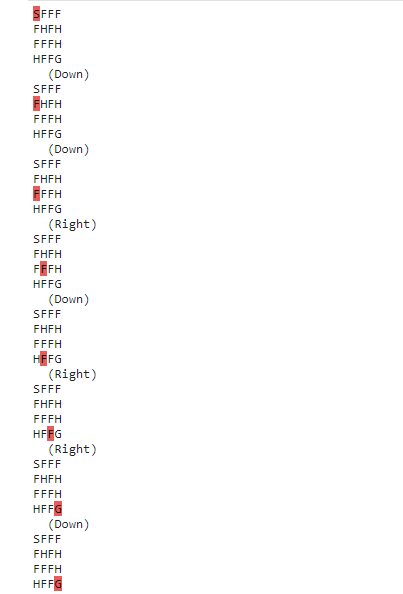

**NOTE: Image of visualization added as the pdf was not highlighting the steps**



In [ ]:
poli  = all_policy[5]
visualize_episode(env,poli)


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG


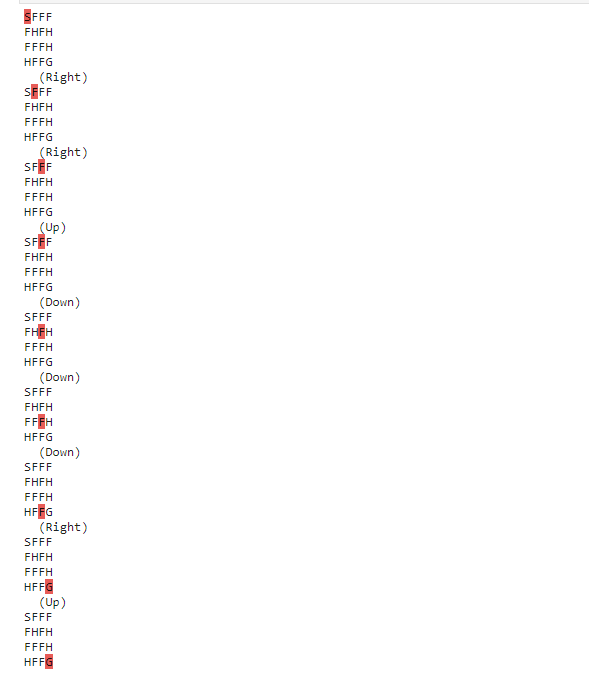

**NOTE: Image of visualization added as the pdf was not highlighting the steps**



### 1.2 (c) Average Undiscoutned return for last 100 episodes 

In [ ]:
#Average return for the last 100 episodes
log_end_100 = np.asarray(log_u_rt)[:,1900:]
average_over_episode = log_end_100.mean(axis=0)
average_over_runs = average_over_episode.mean()
print(average_over_runs)

-44.908999999999985


The average undiscounted is lower than expected as for the last 100 episodes as towards the end the MC is converging  as the number of first-visits to s goes to infinity.

In [ ]:
# ONE of The Learned Policy
poli = all_policy[0]
poli

array([[0.0125, 0.0125, 0.9625, 0.0125],
       [0.0125, 0.0125, 0.9625, 0.0125],
       [0.0125, 0.9625, 0.0125, 0.0125],
       [0.9625, 0.0125, 0.0125, 0.0125],
       [0.0125, 0.0125, 0.0125, 0.9625],
       [0.0125, 0.0125, 0.0125, 0.9625],
       [0.0125, 0.9625, 0.0125, 0.0125],
       [0.0125, 0.9625, 0.0125, 0.0125],
       [0.0125, 0.0125, 0.0125, 0.9625],
       [0.0125, 0.9625, 0.0125, 0.0125],
       [0.9625, 0.0125, 0.0125, 0.0125],
       [0.0125, 0.0125, 0.9625, 0.0125],
       [0.9625, 0.0125, 0.0125, 0.0125],
       [0.0125, 0.0125, 0.9625, 0.0125],
       [0.0125, 0.0125, 0.9625, 0.0125],
       [0.9625, 0.0125, 0.0125, 0.0125]])

## Ans 1.3: 

### Ordinary Importance Sampling

In [ ]:
def OIS(env, episodes, policy, epsilon=0.05,gamma = 0.99):#env,episodes,policy,epsilon=0.05):
    Q = create_state_action_dictionary(env)
    C = np.zeros(env.observation_space.n)#create_state_action_dictionary(env)
    V = np.zeros(env.observation_space.n)
    target_policy = policy
    b_policy = create_random_policy(env)#np.empty((env.observation_space.n,env.action_space.n)).fill(0.25)
    V_state = np.zeros((episodes,env.observation_space.n))
    for i in range(episodes): 
        episode = generate_episode(env=env, policy=b_policy, render=False)
        G = 0.0
        W = 1
        # For each step in the episode, backwards
        for t in reversed(range(0, len(episode))):   #range(len(episode))[::-1]:
            # print("t",t)
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = gamma * G + reward
            C[state] += 1
            V[state] += (W / C[state]) * (G - V[state])
            W *= (target_policy[state][action]/b_policy[state][action])
        V_state[i] = V #.append(V)
    return V_state, target_policy

In [ ]:
V_runs = []
t_policy  = all_policy[0]

for i in range(10):
    # print("runs",i)
    V,t_p = OIS(env, episodes=2000, policy=t_policy, epsilon=0.05,gamma = 0.99)
    V_runs.append(V)

Plot of OIS Value for state S=0,3,7,14



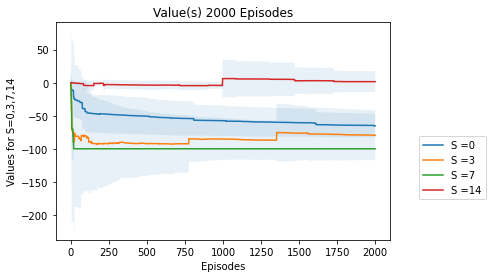

In [ ]:
v_s0 = np.asarray(V_runs)[:,:,0]
v_s3_ois = np.asarray(V_runs)[:,:,3]
v_s7_ois = np.asarray(V_runs)[:,:,7]
v_s14_ois = np.asarray(V_runs)[:,:,14]

def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
                        mean_exp - std_exp, color=color, alpha=0.1)
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Episodes")
    plt.ylabel("Values for S=0,3,7,14")
    plt.title("Value(s) "+ str(2000) + " Episodes")
plot_many(v_s0,label = "S =0")
plot_many(v_s3_ois,label = "S =3")
plot_many(v_s7_ois,label = "S =7")
plot_many(v_s14_ois,label = "S =14")

### Weighted Importance Sampling

In [ ]:
def WIS(env, episodes, target_policy,b_policy, epsilon=0.05,gamma = 0.99):
    C = np.zeros(env.observation_space.n)
    V = np.zeros(env.observation_space.n)
    V_state = np.zeros((episodes,env.observation_space.n))#[]
    for i in range(episodes): 
        episode = generate_episode(env=env, policy=b_policy, render=False)
        G = 0.0
        W = 1
        for t in reversed(range(0, len(episode))):#range(len(episode))[::-1]:
            if W ==0:
              break
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = gamma * G + reward
            C[state] += W
            V[state] += (W / C[state]) * (G - V[state])
            W = W * (target_policy[state][action]/b_policy[state][action])
        V_state[i] = V#.append(V)
    return V_state, target_policy   

In [ ]:
V_runs_wis = []
t_policy = all_policy[0]
b_policy = create_random_policy(env)
episodes = 2000
for i in range(10):
    # print("runs",i)
    V_wis,t_p = WIS(env, episodes, t_policy,b_policy, epsilon=0.05,gamma = 0.99)
    V_runs_wis.append(V_wis)

Plot of WIS Value for state S=0,3,7,14


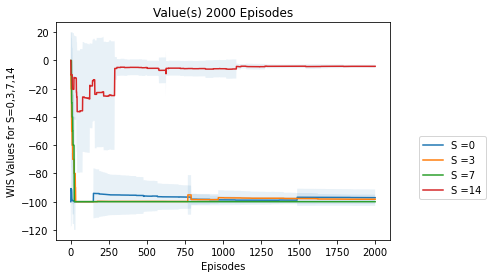

In [ ]:
v_s0_wis = np.asarray(V_runs_wis)[:,:,0]
v_s3_wis = np.asarray(V_runs_wis)[:,:,3]
v_s7_wis = np.asarray(V_runs_wis)[:,:,7]
v_s14_wis = np.asarray(V_runs_wis)[:,:,14]

def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
                        mean_exp - std_exp, color=color, alpha=0.1)
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Episodes")
    plt.ylabel("WIS Values for S=0,3,7,14")
    plt.title("Value(s) "+ str(2000) + " Episodes")

plot_many(v_s0_wis,label="S =0")
plot_many(v_s3_wis,label="S =3")
plot_many(v_s7_wis,label="S =7")
plot_many(v_s14_wis,label="S =14")



Plot of OIS and WIS V(s) for state s=0


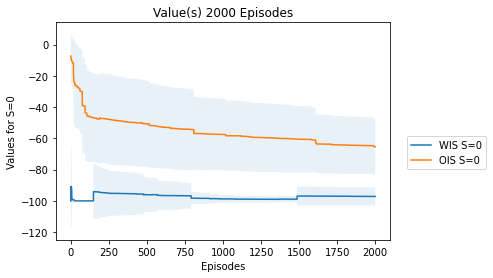

In [ ]:
v_s0_wis = np.asarray(V_runs_wis)[:,:,0]
v_s0_ois = np.asarray(V_runs)[:,:,0]
def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
                        mean_exp - std_exp, color=color, alpha=0.1)
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Episodes")
    plt.ylabel("Values for S=0")
    plt.title("Value(s) "+ str(2000) + " Episodes")

    # plt.show()
plot_many(v_s0_wis,label="WIS S=0")
plot_many(v_s0_ois,label="OIS S=0")  


Plot of OIS and WIS V(s) for state s=3


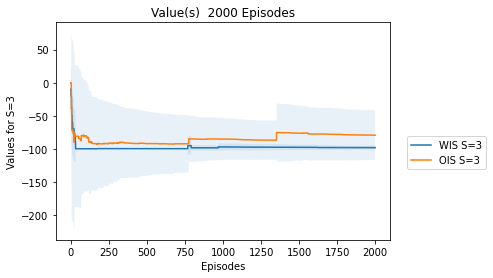

In [ ]:
v_s3_wis = np.asarray(V_runs_wis)[:,:,3]
v_s3_ois = np.asarray(V_runs)[:,:,3]
def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
                        mean_exp - std_exp, color=color, alpha=0.1)
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Episodes")
    plt.ylabel("Values for S=3")
    plt.title("Value(s)  "+ str(2000) + " Episodes")

    # plt.show()
plot_many(v_s3_wis,label="WIS S=3")
plot_many(v_s3_ois,label="OIS S=3")

Plot of OIS and WIS V(s) for state s=7


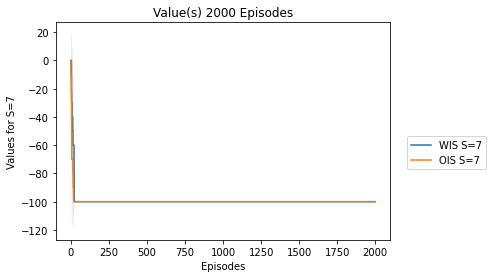

In [ ]:
v_s7_wis = np.asarray(V_runs_wis)[:,:,7]
v_s7_ois = np.asarray(V_runs)[:,:,7]
def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
                        mean_exp - std_exp, color=color, alpha=0.1)
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Episodes")
    plt.ylabel("Values for S=7")
    plt.title("Value(s) "+ str(2000) + " Episodes")


plot_many(v_s7_wis,label="WIS S=7")
plot_many(v_s7_ois,label="OIS S=7")

Plot of OIS and WIS V(s) for state s=14


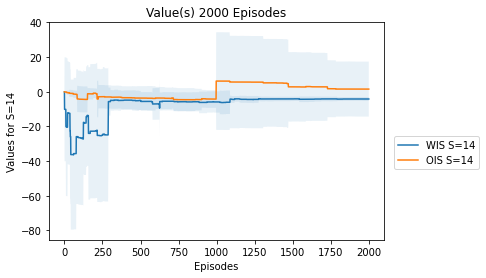

In [ ]:
v_s14_wis = np.asarray(V_runs_wis)[:,:,14]
v_s14_ois = np.asarray(V_runs)[:,:,14]
def plot_many(experiments, label=None, color=None):
    mean_exp = np.mean(experiments, axis=0)
    std_exp = np.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
                        mean_exp - std_exp, color=color, alpha=0.1)
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Episodes")
    plt.ylabel("Values for S=14")
    plt.title("Value(s) "+ str(2000) + " Episodes")

plot_many(v_s14_wis,label="WIS S=14")
plot_many(v_s14_ois,label="OIS S=14")

### 1.3 (b)

We can see that variance for first-visit monte carlo with ordinary importance sampling is higher because the ratios of the variance are unbounded due to returns being unbounded. Ordinary importance sampling is unbiased. Whereas for weighted importance sampling the largest weight on any single return is one.Weighted importance sampling has bounded returns due to which the variance converges to zero. Weighted importance sampling is though in statiscal sense biased as for a return which was the only one observed its expectation is $v_b(s)$ rather than $v_{\pi}(s)$

## Ans 2

In [ ]:
env = FrozenLakeEnv(map_name="4x4-easy", slip_rate=0.0)
# env = FrozenLakeEnv(map_name="4x4", slip_rate=0.0)
policy = create_random_policy(env)

In [ ]:
#Initial policy for all action given states = 0.25
print("Policy = ",policy)

Policy =  [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


### 2.1 *Every Visit Monte Carlo*

In [ ]:
def monte_carlo_every_visit(env, episodes=10000, policy=None, epsilon=0.01):
    # if not policy:
    policy = np.ones((env.observation_space.n,env.action_space.n))#create_random_policy(env)  # Create an empty dictionary to store state action values    
    policy = policy/policy.sum(axis=1,keepdims=True)
    V = np.zeros(env.observation_space.n)
    returns = {}
    gamma = 0.99
    N = [0]*env.nS
    log_returns_per_episode = []

    log_values = np.zeros((episodes,env.observation_space.n))#[]
    for i in range(episodes): 
        G = 0.0
        # print("episode",i)
        episode = generate_episode(env=env, policy=policy, render=False) # Store state, action and value respectively 
        for j in reversed(range(0, len(episode))):   
            s_t, a_t, r_t = episode[j] 
            state_action = (s_t, a_t)
            G = (G*gamma)+ r_t # Increment total reward by reward on current timestep modify
            N[s_t] +=1 
            if returns.get(s_t):
                returns[s_t].append(G)
            else:
                returns[s_t] = [G]   
            V[s_t] = sum(returns[s_t])/len(returns[s_t]) # Average reward across episodes
        # print("V",V[2])
        log_returns_per_episode.append(G)
        log_values[i] = V #.append(V)

    return log_returns_per_episode,log_values

In [ ]:
episodes = 10000
policy = create_random_policy(env)
returns,V_es = monte_carlo_every_visit(env, episodes=10000, policy=policy, epsilon=0.01)#,gamma = 0.99)

Plot V(s) i.e for each that over 10000 episodes




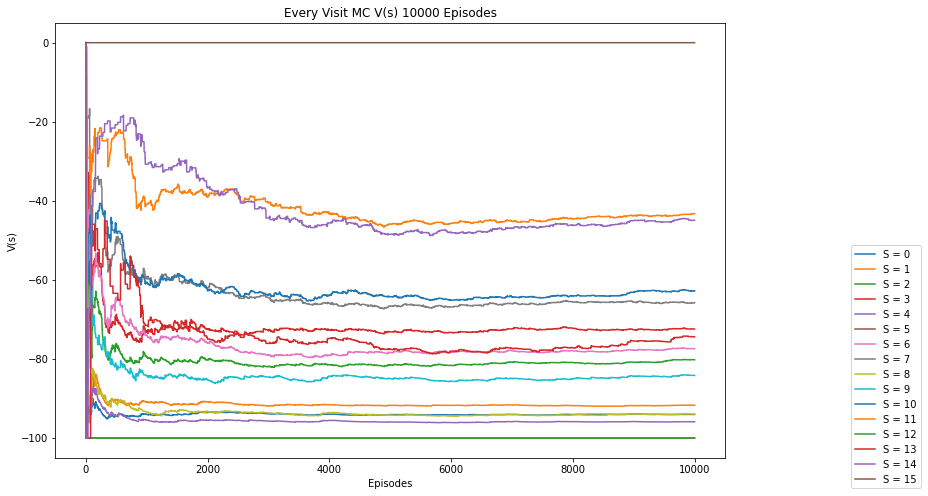

In [ ]:
plt.figure(figsize=(12,8))
# plt.plot(V[0])#V[:,0])
# plt.plot(V[:,1])
# plt.plot(V[:,2])
for i in range(16):
    plt.plot(V_es[:,i],label ="S = "+str(i) )
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("V(s)")
plt.title("Every Visit MC V(s) "+ str(10000) + " Episodes")
plt.show()


Visualize the learned Values in Grid form

In [ ]:
V_final = V_es[9999,:]
print('--------------------------------------')

print('|',' ','\t','|',' ','\t',' |',' ','\t', '  |',' ','\t','    |',)

print('|',round(V_final[0],2),' |',round(V_final[1],2),'|',round(V_final[2],2),'|',round(V_final[3],2),'  |',)

print('--------------------------------------')

print('|',' ','\t',' |',' ','\t','  |',' ','\t', '   |',' ','     |',)

print('|',round(V_final[4],2),' |',round(V_final[5],2),'|',round(V_final[6],2),'|',round(V_final[7],2),'|',)

print('--------------------------------------')

print('|',' ','\t',' |',' ','\t','  |',' ','\t', '   |',' ','     |',)

print('|',round(V_final[8],2),' |',round(V_final[9],2),'|',round(V_final[10],2),'|',round(V_final[11],2),'|',)

print('--------------------------------------')

print('|',' ','\t',' |',' ','\t','  |',' ','\t', '   |',' ','     |',)

print('|',round(V_final[12],2),' |',round(V_final[13],2),'|',round(V_final[14],2),'|',round(V_final[15],2),'   |',)

print('--------------------------------------')

--------------------------------------
|   	 |   	  |   	   |   	     |
| -94.31  | -92.4 | -81.92 | -74.62   |
--------------------------------------
|   	  |   	   |   	    |        |
| -95.7  | -100.0 | -79.16 | -67.99 |
--------------------------------------
|   	  |   	   |   	    |        |
| -93.25  | -82.92 | -64.06 | -46.01 |
--------------------------------------
|   	  |   	   |   	    |        |
| -100.0  | -75.27 | -44.77 | 0.0    |
--------------------------------------


### Ans 2.1 (b)

Visually looking at the value function value on the grid we can see that the value for the state 'H' has a lower value of -100.0 and the terminal state 'G' has the highest value of 0.0. For example if we start from state s=1 and make the action based on the maximum value of the neighbouring state we will reach the terminal state G with maximum returns. from s=1, the agent will take a right action to s=2 due to it being the maximum value out of the available V(s,a). In the same way it traverses the grid as S=1->(R)s=2->(R)s=3->(D)s=7->(D)s=11->(D)s=15 -->G

### 2.2 TD(0) Prediction Algorithm

In [ ]:
def TD_0(env,policy, episodes, alpha = 0.01, gamma = 0.99, epsilon = 0.1):
    policy = np.ones((env.observation_space.n,env.action_space.n))
    policy = policy/policy.sum(axis=1,keepdims=True)
    V = np.zeros(env.observation_space.n)
    V_logger = np.zeros((episodes,env.observation_space.n))# []
    term_states = [5, 12, 15]
    for i in range(episodes):
        done = False
        s = env.reset()
        while s in term_states:
          s = env.reset()
        while not done:
            action = np.random.choice(env.action_space.n,1,p=policy[s,:])[0]
            new_s, reward, done, info = env.step(action)#[0])
            V[s] += alpha * (reward + (gamma * V[new_s]) - V[s])
            s = new_s
        V_logger[i] =V
    return V_logger

In [ ]:
episodes = 10000
n = 1
alpha = 0.01
V = TD_0(env,policy, episodes, alpha = 0.01, gamma = 0.99, epsilon = 0.01)

Plot V(s) i.e for each that over 10000 episodes


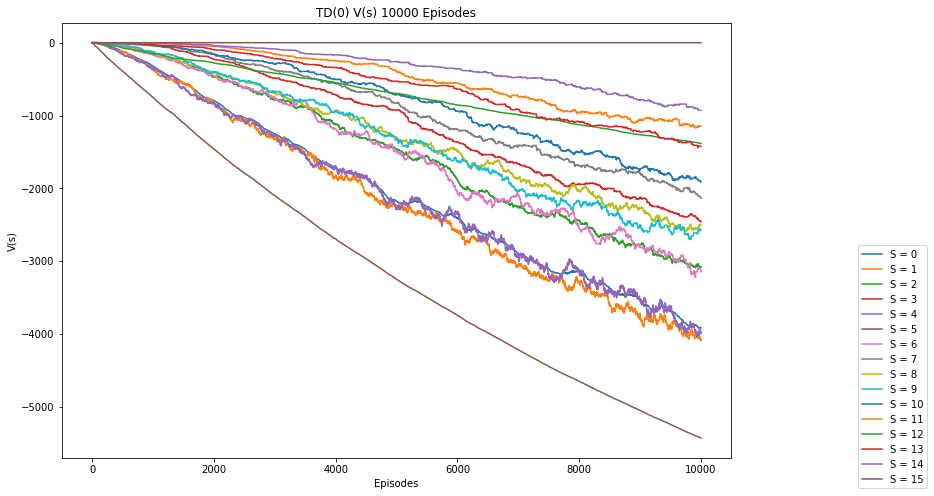

In [ ]:
plt.figure(figsize=(12,8))
for i in range(16):
    plt.plot(V[:,i],label ="S = "+str(i) )
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("V(s)")
plt.title("TD(0) V(s) "+ str(10000) + " Episodes")
plt.show()

### N-step TD Algorithm to estimate V(s)

In [ ]:
def TD_nstep(env, policy, n = 1, alpha=0.01, episodes=2000, gamma=0.99):
  V = np.zeros(env.observation_space.n)
  V_log = np.zeros((episodes, env.observation_space.n))
  term_states = [5, 12, 15]
  for epi in range(episodes):
    s = env.reset()
    while s in term_states:
      s = env.reset()
    T = np.Inf
    done = False
    t = 0
    rewards=[0]
    States=[s]
    G=0.0
    while True:
      if t < T:
        action = np.random.choice(env.action_space.n, 1, p = policy[s,:])[0]
        next_state, reward, done, extra = env.step(action)
        if done:
          T = t+1
        rewards.append(reward)
        States.append(next_state)
      tau = t - n +1
      if tau >= 0:
        G = 0.0
        for i in range(tau+1, min(tau + n, T)+1):
          G += (gamma ** (i - tau - 1)) * rewards[i]
        if tau + n < T:
          G += (gamma ** n) * V[States[tau + n]]
        states_to_update = States[tau]
        if not states_to_update in term_states:
          V[States[tau]] += alpha * (G - V[States[tau]])
        else:
          V[States[tau]]  = reward
      if tau == T-1:
        break
      S = next_state
      t += 1
    # print(V)
    V_log[epi] = V
  return V_log

## Ans 2.3 (a)

In [ ]:
V_test_1 = TD_nstep(env, policy, n = 1, alpha=0.01, episodes=10000, gamma=0.99)

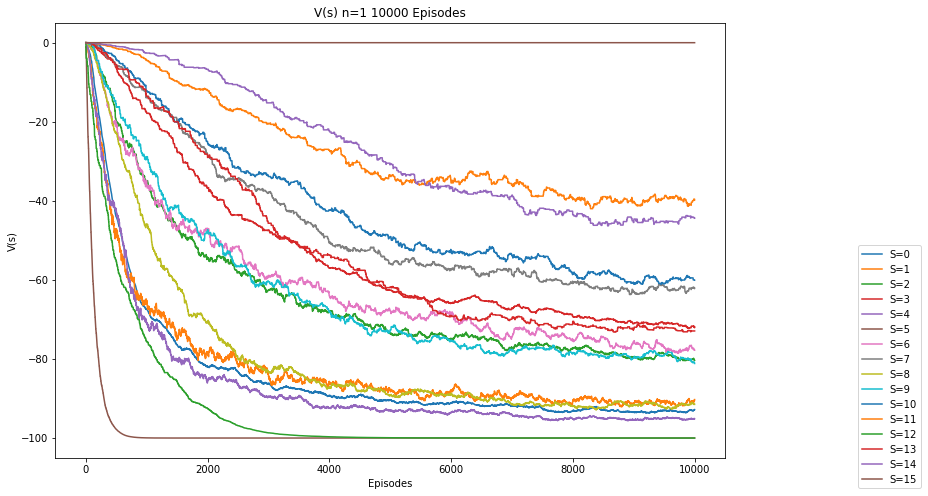

In [ ]:
plt.figure(figsize=(12,8))

for i in range(16):
    plt.plot(V_test_1[:,i],label = "S="+str(i))
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("V(s)")
plt.title("V(s) n=1 "+ str(10000) + " Episodes")
plt.show()


### Ans 2.3 (b) On comparing the plots from Every-visit Monte carlo and TD(0) we can see that the 1-step TD is similar to the TD(0) algorithm. This is due to the fact that the update of 1-step TD and TD(0) is based on just the next reward, bootstrapping from the value of the state one step later as a proxy for the remaining rewards.

## Ans 2.4 (a)

In [ ]:
V_100_step = TD_nstep(env, policy, n = 100, alpha=0.01, episodes=10000, gamma=0.99)

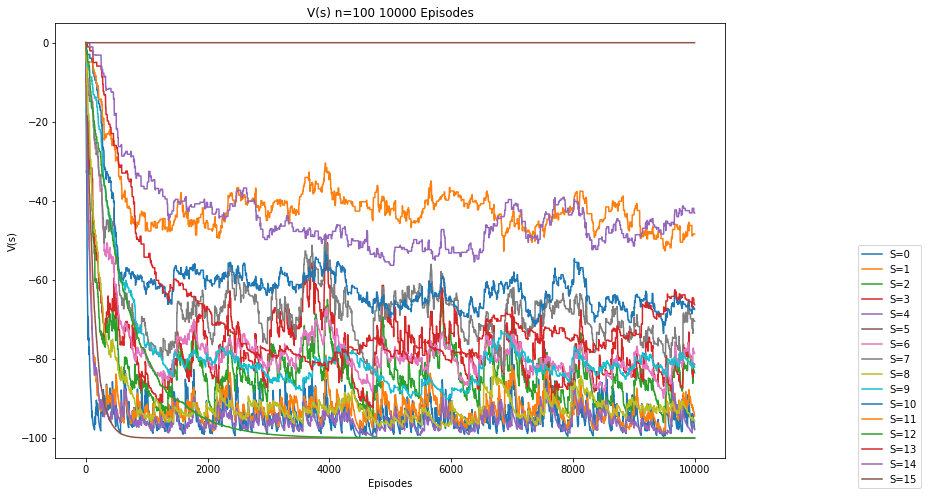

In [ ]:
plt.figure(figsize=(12,8))

for i in range(16):
    plt.plot(V_100_step[:,i],label = "S="+str(i))
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("V(s)")
plt.title("V(s) n=100 "+ str(10000) + " Episodes")
plt.show()


### Ans 2.4 (b)
On comparing the plot for n=100 step TD algorithm we can see that it is not similar to either the plot from Every-visit monte carlo or with TD(0) plot.
The reason for the plot being not similar is that in n-step TD the  updates are still TD methods because they still change an earlier estimate based on how it differs from a later estimate. Now the later estimate is not one step later like in1-step TD or TD(0), but n steps later.

Monte carlo complete return:
$ G_{t} = R_{t+1}+ \gamma R_{t+2}+ \cdots + \gamma^{T-t-1}R_{T} $

In Monte Carlo are the updates estimate the V(s) in the direction of complete return until step T. In Monte Carlo the updates target is the return whereas in 1-step or n-step the updates target for an arbitary n-step update is n-step return given by:
$ G_{t:t+n} = R_{t+1}+ \gamma R_{t+2}+ \cdots + \gamma^{n-1} R_{t+n} + \gamma^{n} V_{t+n-1}(S_{t+n})$

### 2.5 Answer

### Ans 2.5 (a) 
We know that Every-Visit Monte carlo V(s) is calculated as $V(S_t)←V(S_t)+α [G_t −V(S_t) ]$ where alpha is nothing but the inverse of number of times the state $S_t$ was visited to get the average return for the $S_t$.

 Here $G_t$ is given by $ G_{t} = R_{t+1}+ \gamma R_{t+2}+ \cdots + \gamma^{T-t-1}R_{T} $.
In n-step TD value is estimated  using the formula $V(S_t)←V(S_t)+α [G_{t:t+n} −V(S_t) ]$ where $ G_{t:t+n} = R_{t+1}+ \gamma R_{t+2}+ \cdots + \gamma^{n-1} R_{t+n} + \gamma^{n} V_{t+n-1}(S_{t+n})$

The change in the formula we need to do is instead of selecting the step-size alpha, we can make alpha to be equivalent to $1/N(S_t)$ and each update of $V(S_t)$  is average over the returns for the state $S_t$.

$\alpha  = 1/N(S_t) $ is the modification needed to be made.

In [ ]:
#n-step modify to be same as every visit MC
def n_step_TD_mods(env, policy, n = 1, alpha=0.01, num_episodes=2000, gamma=0.99):
  V = np.zeros(env.observation_space.n)
  V_log = np.zeros((num_episodes, env.observation_space.n))
  term_states = [5, 12, 15]
  N = np.zeros(env.observation_space.n)
  for episode in range(num_episodes):
    s = env.reset()
    while s in term_states:
      s = env.reset()
    T = np.Inf
    done = False
    t = 0
    rewards=[0]
    states=[s]
    G=0.0
    while True:
      if t < T:
        action = np.random.choice(env.action_space.n, 1, p = policy[s,:])[0]
        s_t, reward, done, extra = env.step(action)
        if done:
          T = t+1
        rewards.append(reward)
        states.append(s_t)
      N[s] += 1
      tau = t - n +1
      if tau >= 0:
        G = 0.0
        for i in range(tau+1, min(tau + n, T)+1):
          G += (gamma ** (i - tau - 1)) * rewards[i]
        if tau + n < T:
          G += (gamma ** n) * V[states[tau + n]]
        s_update = states[tau]
        alpha = 1/N[states[tau]]
        if not s_update in term_states:
          V[states[tau]] += alpha * (G - V[states[tau]])
        else:
          V[states[tau]]  = reward
      if tau == T-1:
        break
      s = s_t
      t += 1
    V_log[episode] = V
  return V_log

In [ ]:
V_100step_m = n_step_TD_mods(env, policy, n = 100, alpha=0.01, num_episodes=10000, gamma=0.99)

### Ans 2.5 (b)

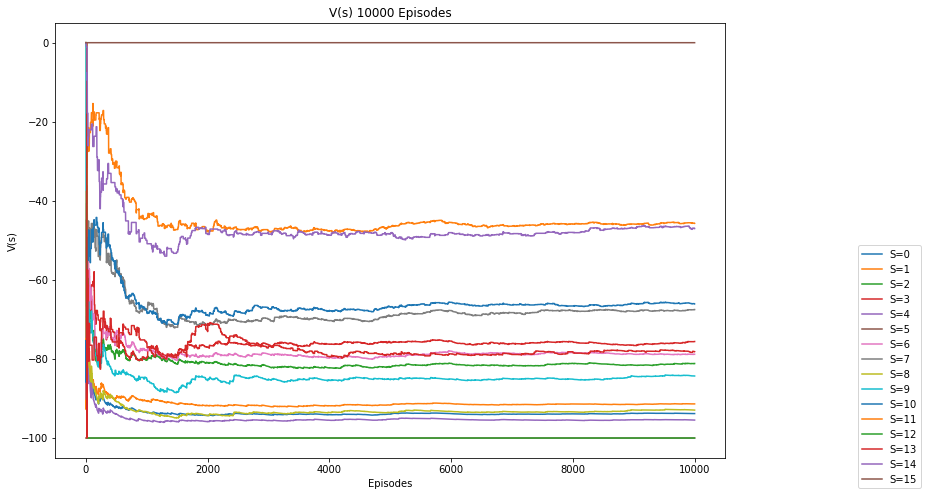

In [ ]:
plt.figure(figsize=(12,8))
for i in range(16):
    plt.plot(V_100step_m[:,i],label = "S="+str(i))
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("V(s)")
plt.title("V(s) "+ str(10000) + " Episodes")
plt.show()

### Ans 2.5 (c)

Yes the plot with modification to the step-size alpha makes the n-step plot for n=100 visually similar to the Every Visit Monte carlo. This is similar to the plot we get for Every-visit monte carlo as after the change of $\alpha = 1/N(S_t)$ we are update the Value estimate with the average of return over the previous steps. And as per the definition of Every visit we know that as the number of visits to s goes to infinity Every-visit converges.

## Ans 3 

In [ ]:
env = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

In [ ]:
def e_greedy_policy(Q,s,eps):
    if np.random.uniform(0,1) < eps:
        # Choose a random action
        return np.random.randint(Q.shape[1]) #check Q
    else:
        return np.argmax(Q[s])   

In [ ]:
def generate_episode_sarsa_q(env,alpha,gamma,Q,epsilon,method):#,render):
    
    env.reset()
    episode = []
    done = False
    state = env.s
    action = e_greedy_policy(Q,state,epsilon)
    total_rew = 0
    rew_epi = []
    render = False
    if method == "sarsa":
        while not done:
            if render:
                #clear_output(True)
                env.render()
                sleep(1)
            next_state, rew, done, _ = env.step(action) # Take one step in the environment
            # choose the next action (needed for the SARSA update)
            next_action = e_greedy_policy(Q, next_state, epsilon) 
            # SARSA update
            Q[state][action] = Q[state][action] + alpha*(rew + gamma*Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
            total_rew += rew
            if done:
                return total_rew#rew_epi.append(total_rew)
    elif method == "q_learning":
        while not done:
            if render:
                #clear_output(True)
                env.render()
                sleep(1)
            action = e_greedy_policy(Q, state, epsilon)
            next_state, rew, done, _ = env.step(action) # Take one step in the environment
            # Q-learning update the state-action value (get the max Q value for the next state)
            Q[state][action] = Q[state][action] + alpha*(rew + gamma*np.max(Q[next_state]) - Q[state][action])

            state = next_state
            total_rew += rew
            if done:
                return total_rew#rew_epi.append(total_rew)
    elif method == "expected_sarsa":
        while not done:
            if render:
                #clear_output(True)
                env.render()
                sleep(1)
            next_state, rew, done, _ = env.step(action) # Take one step in the environment
            # choose the next action (needed for the SARSA update)
            next_action = e_greedy_policy(Q, next_state, epsilon) 
            #expected Sarsa
            expected_q = np.mean(Q[next_state,:])
            # Expected SARSA update
            Q[state][action] = Q[state][action] + alpha*(rew + gamma*expected_q - Q[state][action])
            state = next_state
            action = next_action
            total_rew += rew
            if done:
                return total_rew#rew_epi.append(total_rew)
    else:
        return None

            

### 3.1 SARSA Control

In [ ]:
#Sarsa Control
def sarsa(env,episodes,alpha,gamma,epsilon,method):
#     Q = np.random.random((env.observation_space.n,env.action_space.n))
    Q = np.zeros((env.observation_space.n,env.action_space.n))
    reward_episodes = []
    for i in range(episodes):
#         state = env.s
#         action = e_greedy_policy(Q,state,epsilon)
        total_rew = generate_episode_sarsa_q(env,alpha,gamma,Q,epsilon,method)
        reward_episodes.append(total_rew)
    return reward_episodes,Q
        

In [ ]:
alpha = 0.1
gamma = 0.99
# Q = 
epsilon = 0.01
method = "sarsa"
episodes = 2000
run_returns = []
Q_log = []
seed = [1010,2334,8919,9919,2543,4856,555,3998,7878,865]
for i in range(len(seed)):
    env.seed(seed[i])
    np.random.seed(seed[i])
    random.seed(seed[i])
    returns,Q = sarsa(env,episodes,alpha,gamma,epsilon,method)
    run_returns.append(returns)
    Q_log.append(Q)

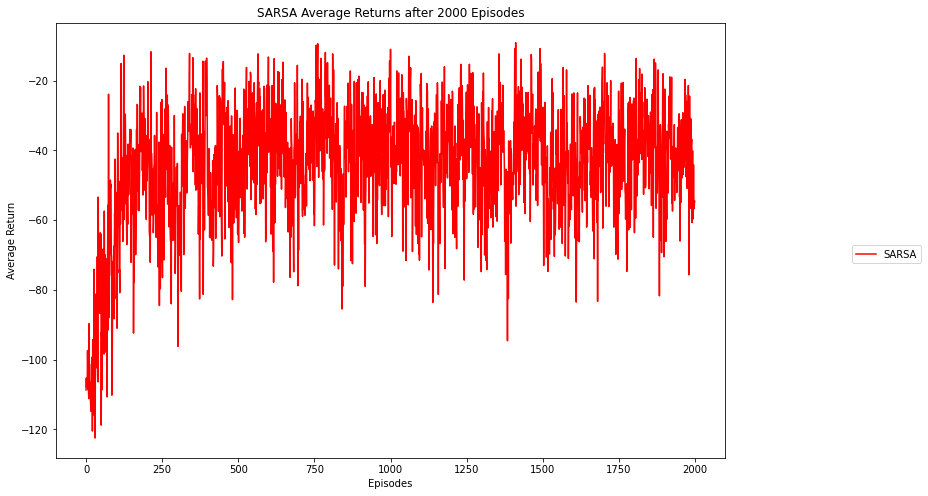

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.asarray(run_returns).mean(axis=0),'r',label="SARSA")

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("Average Return")
plt.title("SARSA Average Returns after "+ str(2000) + " Episodes")
plt.show()


In [ ]:
#Visualise
done = False
Q_test = Q_log[1]
s = env.reset()
game_rew = 0
render = True
while not done:
    if render:
        #clear_output(True)
        env.render()
        sleep(1)
    next_state, rew, done, _ = env.step(np.argmax(Q_test[s])) # Take one step in the environment
    s = next_state
    game_rew +=rew
    if done:
        break
    


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


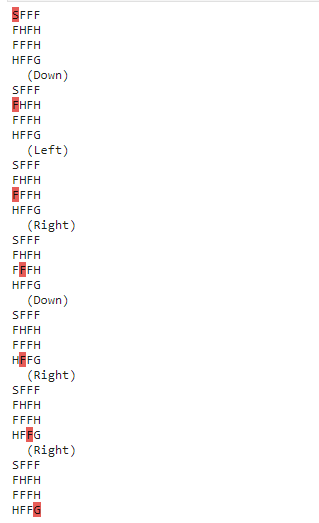

**NOTE: Image of visualization added as the pdf was not highlighting the steps**



### 3.2 Expected SARSA

In [ ]:
#Expected Sarsa Control
def sarsa_expected(env,episodes,alpha,gamma,epsilon,method):
#     Q = np.random.random((env.observation_space.n,env.action_space.n))
    Q = np.zeros((env.observation_space.n,env.action_space.n))
    reward_episodes = []
    for i in range(episodes):
#         state = env.s
#         action = e_greedy_policy(Q,state,epsilon)
        total_rew = generate_episode_sarsa_q(env,alpha,gamma,Q,epsilon,method)
        reward_episodes.append(total_rew)
    return reward_episodes,Q

In [ ]:

alpha = 0.2
gamma = 0.99
# Q = 
epsilon = 0.01
method = "expected_sarsa"
episodes = 2000
run_returns = []
Q_log = []
seed = [1010,2334,8919,9919,2543,4856,555,3998,7878,865]
for i in range(len(seed)):
    env.seed(seed[i])
    np.random.seed(seed[i])
    random.seed(seed[i])
    returns,Q = sarsa_expected(env,episodes,alpha,gamma,epsilon,method)
    run_returns.append(returns)
    Q_log.append(Q)

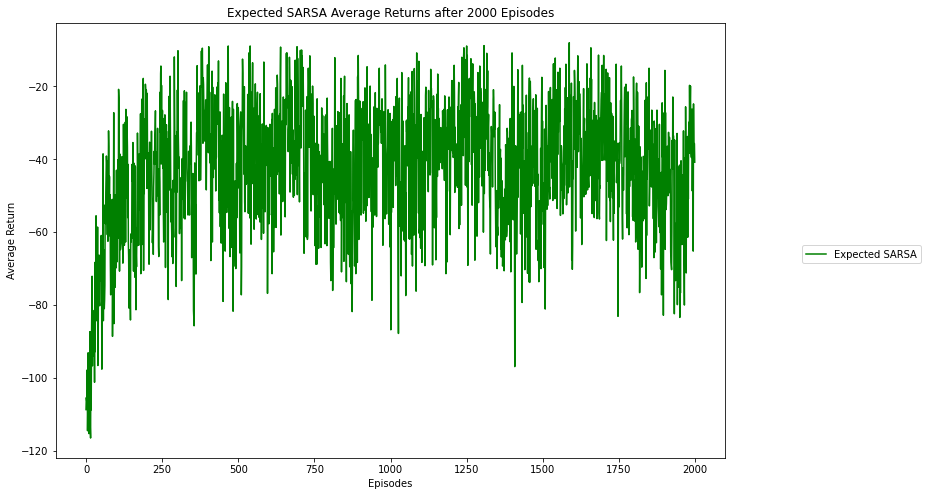

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.asarray(run_returns).mean(axis=0),'g',label="Expected SARSA")

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("Average Return")
plt.title("Expected SARSA Average Returns after "+ str(2000) + " Episodes")
plt.show()


In [ ]:
#Visualise
done = False
Q_test = Q_log[2]
s = env.reset()
game_rew = 0
render = True
while not done:
    if render:
        #clear_output(True)
        env.render()
        sleep(1)
    next_state, rew, done, _ = env.step(np.argmax(Q_test[s])) # Take one step in the environment
    s = next_state
    game_rew +=rew
    if done:
        break
    


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


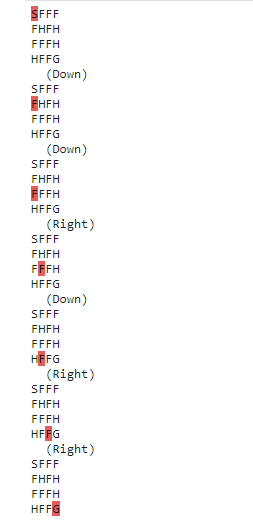

**NOTE: Image of visualization added as the pdf was not highlighting the steps**



### 3.3 Q-Learning

In [ ]:
#Q-learning
def q_learning(env,episodes,alpha,gamma,epsilon,method):
#     Q = np.random.random((env.observation_space.n,env.action_space.n))
    Q = np.zeros((env.observation_space.n,env.action_space.n))
    reward_episodes = []
    for i in range(episodes):
        total_rew = generate_episode_sarsa_q(env,alpha,gamma,Q,epsilon,method)
        reward_episodes.append(total_rew)
    return reward_episodes,Q

In [ ]:
alpha = 0.1
gamma = 0.99
epsilon = 0.02
method = "q_learning"
episodes = 2000
run_returns = []
Q_log = []
seed = [1010,2334,8919,9919,2543,4856,555,3998,7878,865]
for i in range(len(seed)):
    env.seed(seed[i])
    np.random.seed(seed[i])
    random.seed(seed[i])
    returns,Q = q_learning(env,episodes,alpha,gamma,epsilon,method)
    run_returns.append(returns)
    Q_log.append(Q)

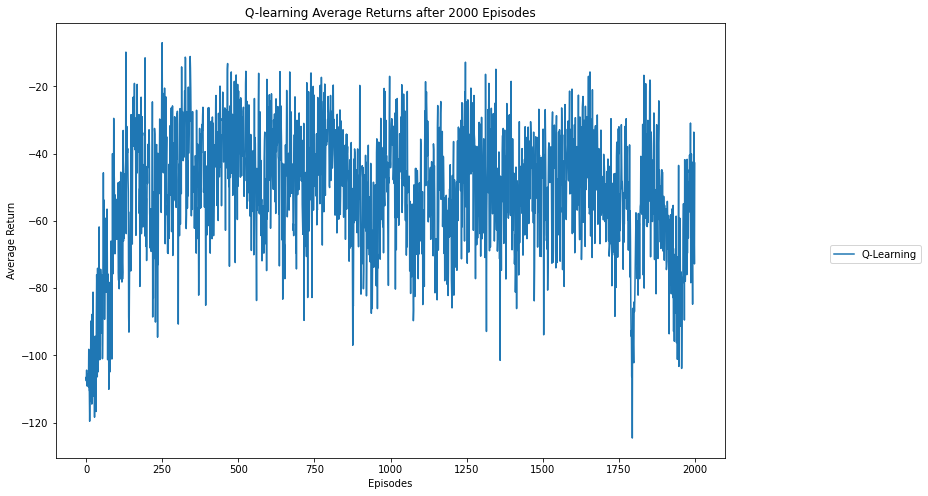

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.asarray(run_returns).mean(axis=0),label="Q-Learning")

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Episodes")
plt.ylabel("Average Return")
plt.title("Q-learning Average Returns after "+ str(2000) + " Episodes")
plt.show()


In [ ]:
#Visualise
done = False
Q_test = Q_log[7]
s = env.reset()
game_rew = 0
render = True
while not done:
    if render:
        #clear_output(True)
        env.render()
        sleep(1)
    next_state, rew, done, _ = env.step(np.argmax(Q_test[s])) # Take one step in the environment
    s = next_state
    game_rew +=rew
    if done:
        break
    


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


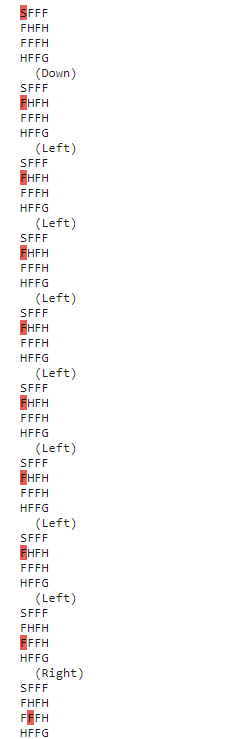

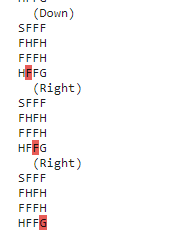

**NOTE: Image of visualization added as the pdf was not highlighting the steps**



### 3.4 Answer

The monte-carlo methods in Q1 need to wait until the end of the episode to know the return. Monte-Carlo methods have a high variance and low bias. Monte-carlo do not exploit the Markov Property. Convergence is slower than TD methods when taking constant-$\alpha$ MC, and monte-carlo methods have lower error on past data but higher future data error.

Whereas Temporal Difference Learning methods learn online after every step and need wait for the completion of episode. TD methods have low variance and a decently acceptable bias. TD methods exploit the Markov property.TD methods beacuse of the online nature require less memory and less peak computation.
TD methods do not require the model of the environment only experience is needed. TD methods can be fully incremental and learn without the final outcome from the incomplete sequence.

If the world is truly markov then TD methods will converge faster than Monte Carlo.

From the plots we can also see that TD methods have lower variance when compared to monte carlo methods.

TD learning is exposed to 3 factors, that can each vary (in principle, depending on the environment) over a single time step:
- What reward Rt+1 will be returned
- What the next state St+1 will be.
- What the policy will choose for At+1

whereas Monte Carlo return depends on every return, state transition and policy decision from $(S_t,A_t)$ up to $S_T$. As this is often multiple time steps, the variance will also be a multiple of that seen in TD learning on the same problem